# SCRIPT 2

Combine processed files into a single drifter dataset, then annotate by deployment?

In [1]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Import modules

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import datetime
import gsw
import os
import glob
import sys
import re
from scipy import stats
import time


%load_ext autoreload
%autoreload 2

# Local import
# > Make sure SIO_wrap dir is on the same path as this script.

from SIO_wrap import dir_tree, fnames
from SIO_wrap.lowess import LatLonLocalWess
from SIO_wrap import jlab_python as jlab
from SIO_wrap import drifter_qc as dqc

from setdir import *



/Users/eddifying/Python/drifters/ already exists
/Users/eddifying/Python/drifters/02-code/ already exists
/Users/eddifying/Python/drifters/02-code/SIO_wrap/ already exists
/Users/eddifying/Python/drifters/01-data/04-aux/ already exists
/Users/eddifying/Python/drifters/01-data/02-intermediate/ already exists


# User edits

In [2]:
# Path for the output data
data_dir = dir_tree.dir_out

#------------
# Names of variables
latname = 'GPS_Latitude_deg'
lonname = 'GPS_Longitude_deg'
uvelname = 'uvel'
vvelname = 'vvel'

#--------------
# Time formats
tstamp_strftime = '%Y%m%d'  # Filename timestamp
timcol_strftime = '%Y-%m-%d %H:%M:%S'  # Convert text to datetime format 

# Reference date for computing time in seconds
# Can use an earlier time reference if data start before 2000
ref_time = datetime.datetime(2000, 1, 1)

#--------------
# List of variable names split between float/int types based on whether the 
# variables are continuous or discrete, respectively.
# <!> If the names of variables change, update the lists by printing a list of 
# all the names from the raw datafile: list(xarrayDataset.keys())

integ_vars = ['Drogue_cnts', 'GPS_HDOP', 'GPS_FixDelay', 'GPS_TTFF', 
              'GPS_NumSat', 'SBD_Transmit_Delay', 'SBD_Retries']

float_vars = [lonname, latname, 'SST_degC',
              'SLP_mB', 'Battery_volts', uvelname, vvelname]


# Step 1. Load raw data

Check the list of PIDs and decide which ones need to be updated.

In [4]:
# Check the list of Platform IDs for TERIFIC
PID = pd.read_csv(cat_proc_path('PID_list.txt'), header='infer', index_col=0)

# Check whether a given Platform ID has been processed and is up-to-date
# If not, then add it to the update list
PID_to_update = []
counter = 0


# Extract a list with the names of existing raw data files.
for i in [1]: 
#range(len(PID)):
    pid1 = (PID["PID"].values)[i].astype('str')
    PID1 = (PID["PID"].values)[i]

    # Extract a list with the names of existing raw data files.
    fname = 'pid'+str(PID1)+'_*'
    existing_files = glob.glob(cat_interim_path(fname))

    # Check whether any files exist in the intermediate directory for that PID
    if len(existing_files) > 0:

        # Extract the end date from the filename
        existing_files = sorted(existing_files)
        # Needs existing_files to be sorted() so the last one is latest
        end_date = (existing_files[-1])[-11:-3] 
        t1 = datetime.datetime.strptime(end_date, '%Y%m%d')  

        # Check what the latest raw file was
        raw_files = glob.glob(cat_raw_path(fname))
        if not len(raw_files) > 0:
            print('No raw file for that PID!')

        # Check the end date
        raw_files = sorted(raw_files)
        end_date_raw = (raw_files[-1])[-11:-3]
        t_raw = datetime.datetime.strptime(end_date_raw, '%Y%m%d')

        if t1==t_raw:
            print('pid('+pid1+') - Up to date processed file exists')

        else:
            counter += 1
            PID_to_update.append(PID1)
            print(str(counter)+'. pid('+pid1+') - Ended:'+end_date
                  +', New end:'+t_raw)

    else:
        counter += 1
        print(str(counter)+'. pid('+pid1
              +') - No previous raw data files.')
        PID_to_update.append(PID1)

pid(300234068243970) - Up to date processed file exists


In [29]:
# Load a raw file to process it
# Check the list of Platform IDs for TERIFIC
PID = pd.read_csv(cat_proc_path('PID_list.txt'), header='infer', index_col=0)

start_time = np.ones(len(PID))
end_time = start_time
numel = start_time

for i in range(len(PID)):
    pid1 = (PID["PID"].values)[i].astype('str')
    PID1 = (PID["PID"].values)[i]

    ########################################################################
    ######## Load the filtered, hourly data
    fname = 'pid'+str(PID1)+'_*'
    proc_files = glob.glob(cat_interim_path(fname))
    if len(proc_files):
        proc_files = sorted(proc_files)
        # Find the most recent file (alphabetically, rather than by time)
        proc_files = proc_files[-1]
        # Open the dataset
        ds_hourly = xr.open_dataset(proc_files)

        tmin = ds_hourly.time.min().values
        tmax = ds_hourly.time.max().values

        start_time[i] = tmin
        end_time[i] = tmax
        numel[i] = len(ds_hourly.time)



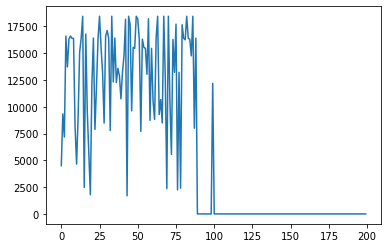

In [28]:

plt.plot(numel)

In [14]:
ds_hourly.time.min().values
#ds_hourly.time.max().values

numpy.datetime64('2020-06-15T12:00:00.000000000')

In [ ]:
if 0:

    # ~ ~ print update ~ ~ 
    if len(existing_files) > 0:
        print("Existing raw data files: \n%s\n" % existing_files)
    else:
        sys.exit("No previous raw data files.\n")

    # ~ ~ filenaming convention ~ ~
    # If there are multiple files with raw data (i.e. non-updated datasets), select 
    # the latest one updated.
    # The file names are distinguished by the timestamp appended to the filename 
    # and has <tstamp_strftime> format (see 'user edits' section).
    # The data are cropped such that the last day is fully sampled (spans 0h-23h).
    # The timestamp in the filename is the latest downloaded fully sampled day.

    # Extract the timestamp part of the filename(s) in a list
    tstamp = [date for file in existing_files 
                for date in re.findall("(\d{8})", file)]

    # Convert to datetime and pick the most recent timestamp
    tstamp_date = pd.to_datetime(tstamp, format=tstamp_strftime)
    fname_timestamp = tstamp[tstamp_date.argmax()]

    # Load the raw file with the latest timestamp
    ds_fname = f"{fnames.fname_rawdata}{fname_timestamp}.nc"
    ds_fpath = os.path.join(data_dir, ds_fname)

    print("Opening file: %s\n" % ds_fpath)
    ds_raw = xr.open_dataset(ds_fpath)
